In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Continued-Fractions/notebooks')

In [2]:
!pip install numba-progress

In [4]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from mpmath import mp
from matplotlib import animation
from numba_progress import ProgressBar

In [5]:
plt.style.use('dark_background')

In [6]:
from mpmath import khinchin as K
K = float(K)
mp.dps = 150
K

2.6854520010653062

In [7]:
import sys
# Append parent dir to path, so that other modules can be imported.
sys.path.append('../')

## Gauss–Kuzmin distribution

The Gauss–Kuzmin distribution is a discrete probability distribution that arises as the limit probability distribution of the coefficients in the continued fraction expansion of a random variable uniformly distributed in $(0, 1)$.

$$ PMF(k) = -\log_2\left[1-\frac{1}{(k+1)^2}\right] $$
$$ CDF(k) = 1-\log_2\left(\frac{k+2}{k+1}\right) $$

In [8]:
pmf = lambda k: -np.log2(1-(1/((k+1)**2)))
cdf = lambda k: 1 - np.log2((k+2)/(k+1))

$$ PMF^{-1}(k) = -1 + \frac{\sqrt{2^k(2^k-1)}}{2^k-1} $$
$$ CDF^{-1}(k) = -\frac{2(2^k-1)}{2^k-2} $$

In [9]:
def inv_pmf(x):
  a = 1/(1-1/(2**x))
  return -1 + a**.5

def inv_cdf(x):
  a = 2**x - 1
  return -2*a/(a-1)

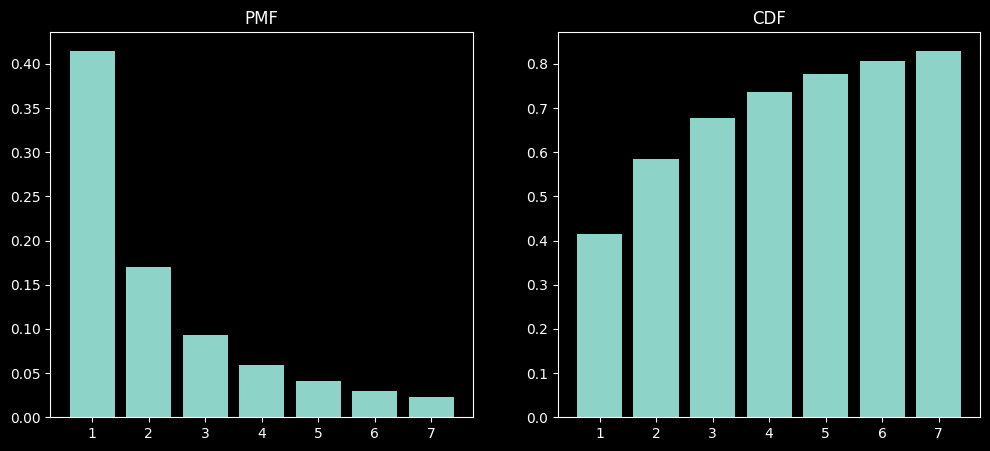

In [10]:
n = 8
x = np.arange(1,n)

fig, ax = plt.subplots(1,2, figsize=(12,5))
plt.sca(ax[0])
plt.bar(x, pmf(x))
plt.title('PMF')
plt.sca(ax[1])
plt.bar(x, cdf(x))
plt.title('CDF')
plt.show()

$$ CDF(k) = \sum_{i=1}^{k} PMF(i)
= -\sum_{i=1}^{k} \log_2\left[1-\frac{1}{(i+1)^2}\right]
= 1-\log_2\left(\frac{k+2}{k+1}\right) $$

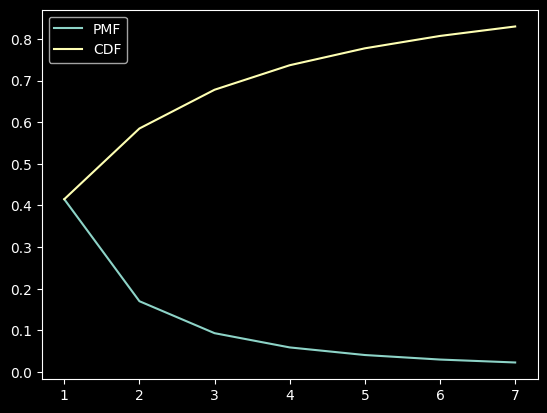

sum of pmf 0.83007 equals cdf 0.83007


In [11]:
plt.plot(x, pmf(x), label='PMF')
plt.plot(x, cdf(x), label='CDF')
plt.legend()
plt.show()

print(f'sum of pmf {pmf(x).sum():.5f} equals cdf {cdf(n-1):.5f}')

In [12]:
from CF_core import compute_num_from_cf, compute_cum_GM, compute_cum_HM

### Uniformly sampling the inverse CDF

Note that you need a discrete inverse for a discrete probability function, not a continuous one. \
For this we can simply take the ceil of the inverse discrete probability function.

In [13]:
x = np.linspace(0,1,100000)[1:-1]
coeffs = np.ceil(inv_cdf(x))

print(compute_cum_GM(coeffs)[-1])

2.6852963413001896


### Building up to the PDF

In [14]:
from modules.visualize import animate_bars

In [15]:
max_val = 10
num_steps = int(np.ceil(1 / pmf(max_val)))
print(f'max val of {max_val} will be reached in {num_steps} steps')
print(f'number of coeffs found would be {int(num_steps * cdf(1+max_val))}')

probs = pmf(np.arange(1, 1+max_val))
# print(probs * 84)

max val of 10 will be reached in 84 steps
number of coeffs found would be 74


In [ ]:
anim = animate_bars(probs, .05, num_steps)
FFWriter = animation.FFMpegWriter(fps=30)
anim.save('../animations/bars.mp4', writer=FFWriter)
plt.close()

  0%|          | 1/1679 [00:00<?, ?it/s]

In [ ]:
from tqdm.auto import tqdm

class Bars():
  def __init__(self, prob_steps):
    self.prob_steps = prob_steps
    nums = np.arange(1, 1+len(prob_steps))
    pmf = lambda k: -np.log2(1-(1/((k+1)**2)))

    self.probs = [0]*len(prob_steps)
    self.coeffs = []

  def update_bars(self):
    num_exceeding = 0
    for i, (prob_step, prob_height) in enumerate(zip(self.prob_steps, self.probs)):
      prob_height += prob_step
      if prob_height >= 1:
        prob_height -= 1
        self.coeffs.append(i+1)
        num_exceeding += 1
      self.probs[i] = prob_height

def animate_bars(probs, scale, steps):
  bars = Bars(probs * scale)
  steps = range(1, int(np.ceil(steps/scale)))
  for _ in tqdm(steps):
    bars.update_bars()
  return bars.coeffs

coeffs = animate_bars(probs, .05, n)
print(coeffs[:25])

  0%|          | 0/2086979 [00:00<?, ?it/s]

[1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 4, 2, 1, 3, 1, 2, 1, 5, 1, 1, 2, 1, 3, 6, 1]


In [ ]:
import numpy as np
from numba import njit
from numba_progress import ProgressBar

num_iterations = 100

@njit(nogil=True)
def numba_function(num_iterations, progress_proxy):
    for i in range(num_iterations):
        np.random.normal(1,1,1000000)
        progress_proxy.update(1)

with ProgressBar(total=num_iterations) as progress:
    numba_function(num_iterations, progress)

In [ ]:
@nb.njit
def pmf_nb(k):
  return -np.log2(1-(1/((k+1)**2)))

@nb.njit
def compute_kuzmin_coeffs(num_steps, probs_scaled, progress_proxy):
# def compute_kuzmin_coeffs(num_steps, probs_scaled):
  updated_probs = np.zeros_like(probs_scaled)

  coeffs = []
  for i in range(1, 1+num_steps):
    updated_probs += probs_scaled
    indices = np.where(updated_probs >= 1)[0]
    if len(indices) > 1:
      raise ValueError('fail')
    elif len(indices) == 1:
      updated_probs[indices[0]] -= 1
      coeffs.append(indices[0] + 1)
    progress_proxy.update(1)
  return np.array(coeffs)

def compute_kuzmin_coeffs_scale(num_steps, max_len, scale):
  probs_scaled = pmf_nb(np.arange(1, 1+max_len)) * scale
  num_steps = int(np.ceil(num_steps/scale))
  with ProgressBar(total=num_steps) as progress:
    coeffs = compute_kuzmin_coeffs(num_steps, probs_scaled, progress)
  # coeffs = compute_kuzmin_coeffs(num_steps, probs_scaled)
  return coeffs


num_steps = 100557
max_val = int(inv_pmf(1/num_steps))

coeffs = compute_kuzmin_coeffs_scale(num_steps, max_val, 0.0001)
print(list(coeffs)[:25])

  0%|          | 0/1005570000 [00:00<?, ?it/s]

[1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 4, 2, 1, 3, 1, 2, 1, 5, 1, 1, 2, 1, 3, 6, 1]


#### Numpy

In [ ]:
def compute_kuzmin_coeffs(num_steps, max_val):
  """Takes `num_steps` * `max_val` space. But `num_steps` is very big
  compared to `max_val` so this is approach not very desirable.
  It is also probably slower than the numba approach and less readable as well."""
  nums = np.arange(1, num_steps+1, dtype=float)
  counts = np.tile(nums[:, None], (1, max_val))
  probs = pmf(np.arange(1, 1+max_val))
  counts *= probs
  counts_diff = np.diff(counts.astype(int), axis=0)
  counts_frac = counts[1:] % 1
  id_x, id_y = counts_diff.nonzero()

  # Sort the indices from highest probability to lowest.
  counts_frac += np.arange(num_steps-1,0,-1)[:, None]
  counts_frac_nonzero = counts_frac[id_x, id_y]
  id_y = id_y[np.argsort(counts_frac_nonzero)[::-1]]

  return id_y + 1

#### Numba

In [ ]:
@nb.njit
def pmf_nb(k):
  return -np.log2(1-(1/((k+1)**2)))

@nb.njit
def compute_kuzmin_coeffs(num_steps, max_val, progress_proxy):
  probs = pmf_nb(np.arange(1, 1+max_val))
  updated_probs = np.zeros_like(probs)

  coeffs = []
  for i in range(1, 1+num_steps):
    updated_probs += probs
    indices = np.where(updated_probs >= 1)[0]
    # Highest probability enters the list first.
    indices = indices[np.argsort(updated_probs[indices])[::-1]]
    updated_probs[indices] -= 1
    coeffs.extend(indices+1)
    progress_proxy.update(1)
  return np.array(coeffs)

#### Calculate and save

In [ ]:
num_steps = 100557  # gives 1e5 coeffs.
# num_steps = 1001754  # gives 1e6 coeffs.

max_val = int(inv_pmf(1/num_steps))
counts = num_steps * pmf_nb(np.arange(1, 1+max_val))

coeffs_len = counts[counts>=1].astype(np.int64).sum()
coeffs_len_upper_bound = num_steps * cdf(1+max_val)
# print(coeffs_len_upper_bound)
print(f'biggest and rarest coeff upto {coeffs_len} coeffs = {max_val}')
# print(np.where(coeffs==379))

kuzmin_coeffs = compute_kuzmin_coeffs(num_steps, max_val)
assert coeffs_len == len(kuzmin_coeffs), f'predicted coeffs len {coeffs_len}' \
                                  f'does not match the len of computed coeffs {len(kuzmin_coeffs)}'
assert coeffs_len_upper_bound >= len(kuzmin_coeffs)
# The 25th coeff differs based on whether you sort based on probs or not.
print(list(kuzmin_coeffs[:25]))

biggest and rarest coeff upto 100000 coeffs = 379
[1, 1, 2, 1, 1, 3, 2, 1, 1, 1, 4, 2, 1, 1, 3, 2, 1, 5, 1, 1, 2, 1, 3, 1, 6]


In [ ]:
try:
    os.mkdir('../consts')
except OSError as error:
  pass
# np.save('../consts/Kuzmin.npy', np.insert(kuzmin_coeffs,0,0))

In [ ]:
means = compute_cum_GM(kuzmin_coeffs)
kuzmin_const = compute_num_from_cf(np.insert(kuzmin_coeffs[:1000], 0, 0))
print('Kuzmin_constant =', float(kuzmin_const))
print(f"approximated khinchin's constant with {len(kuzmin_coeffs)} coeffs = {means[-1]}")
print(f'difference = {K-means[-1]}')

Kuzmin_constant = 0.581580335882833
approximated khinchin's constant with 100000 coeffs = 2.607351964275361
difference = 0.07810003678994537


### Visualize

In [ ]:
nums, freqs = np.unique(kuzmin_coeffs, return_counts=True)
freqs = freqs/freqs.sum()  # Normalize the frequencies.

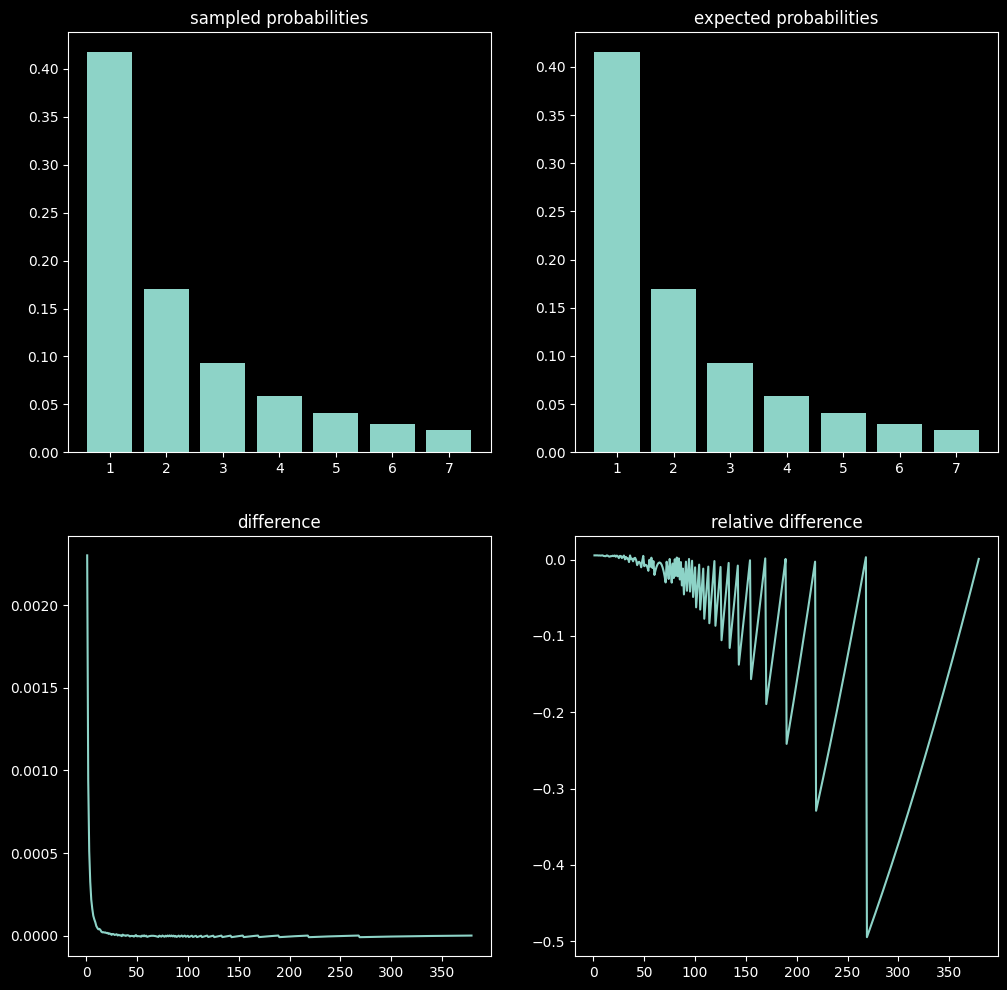

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(12,12))

n = 8
x = np.array(list(range(1,n)))
y = pmf(x)
plt.sca(axs[0,0])
plt.bar(x, freqs[:n-1])
plt.title('sampled probabilities')
plt.sca(axs[0,1])
plt.bar(x, pmf(x))
plt.title('expected probabilities')

x = np.array(list(range(1,1+len(freqs))))
y = pmf(x)
plt.sca(axs[1,0])
plt.plot(x, freqs-y)
# plt.ylim(-6e-6, 3e-5)
plt.title('difference')
plt.sca(axs[1,1])
plt.plot(x, (freqs-y)/y)
plt.title('relative difference')
plt.show()

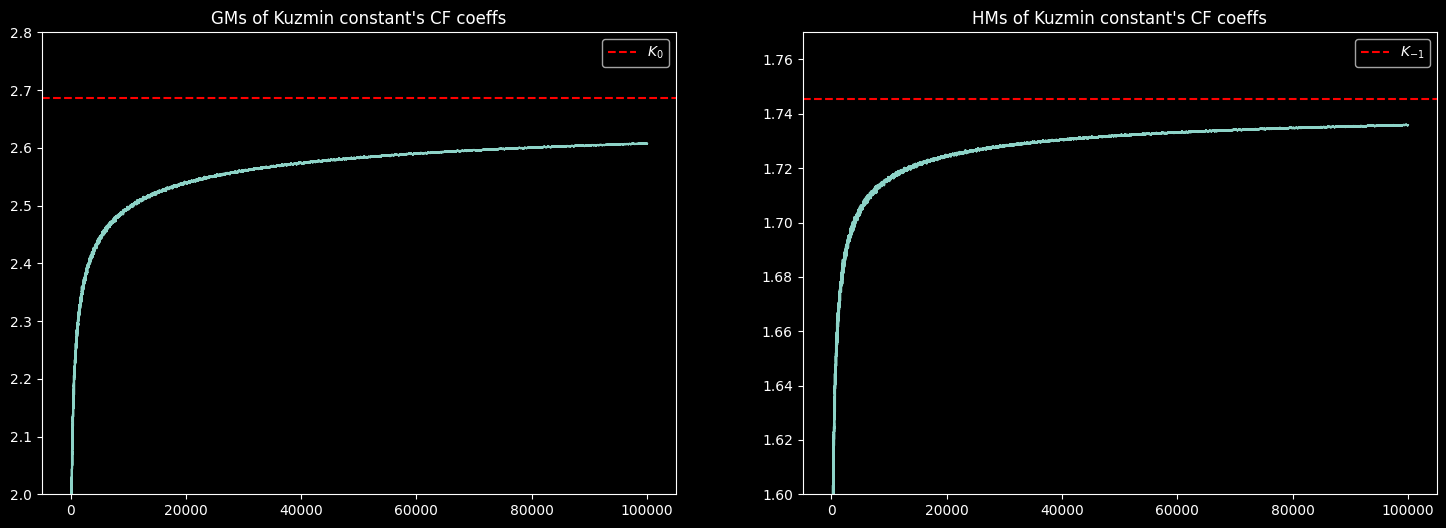

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
line_x_points = np.arange(1, 1+len(means))

plt.sca(ax[0])
plt.plot(line_x_points, means)
plt.axhline(K, label=r'$K_0$', color='r', linestyle='--')
plt.ylim(2, 2.8)
plt.legend()
plt.title("GMs of Kuzmin constant's CF coeffs")

plt.sca(ax[1])
compute_cum_HM = lambda x: np.arange(1, 1+len(x)) / np.cumsum(1/x)
plt.plot(line_x_points, compute_cum_HM(kuzmin_coeffs))
plt.axhline(1.7454056624073468, label=r'$K_{-1}$', color='r', linestyle='--')
plt.ylim(1.6, 1.77)
plt.legend()
plt.title("HMs of Kuzmin constant's CF coeffs")

plt.show()

In [ ]:
from modules.visualize import animate_line_zoom_in, animate_line_zoom_out

In [ ]:
anim = animate_line_zoom_out(line_x_points, (mp.nstr(kuzmin_const, 100) + '...', means))
FFWriter = animation.FFMpegWriter(fps=15)
anim.save('../animations/kuzmin_const.mp4', writer=FFWriter)
plt.close()

  0%|          | 1/1000 [00:00<?, ?it/s]

## Explicit construction using $K_0$

Start with a 3 and pick the next coeff such that the mean converges to $K_0$.


$$ a_{n} = \left \lfloor \frac{{K_0}^{n}}{\prod_{i=1}^{n-1} a_{i} }
\right \rceil = \left \lfloor e^{n\log{K_0} - \sum_{i=1}^{n-1}\log{a_i} } \right \rceil $$

$$ a_ns = [3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, ...] $$

$$ \kappa = \frac{1}{a_1+\frac{1}{a_2+\frac{1}{a_3+\cdots}}} \approx 0.29118210753389373\cdots $$

Note that the coefficients of the reverse Khinchin's coefficient does not follow Gauss-Kuzmin distribution. \
Its Khinchin coefficients $K_p$ would always be different from the expected ones for $p<0$.

$K_{-1}$, $K_{-2}$, $K_{-3}$, $...$ would all be in $(2, 3)$ but the expected values of $K_p$ are all $<2$ for $p<0$.

In [ ]:
def compute_rev_khinchin_coeffs(n: int, round_fn = np.rint) -> np.ndarray[int]:
  log_K = np.log(K)
  log_sum = 0
  coeffs = np.arange(n)
  coeffs[0] = round_fn(K)
  for i in range(1, n):
    log_sum += np.log(coeffs[i-1])
    c = log_K*(i+1) - log_sum
    coeffs[i] = round_fn(np.exp(c))
  return coeffs

def compute_rev_khinchin_coeffs(n: int, round_fn = np.rint) -> np.ndarray[int]:
  prod = K
  coeffs = np.arange(n)
  coeffs[0] = round_fn(K)
  for i in range(1, n):
    prod *= K / coeffs[i-1]
    coeffs[i] = round_fn(prod)
  return coeffs

### Explicit formula for nth term.

A sequence of 2's and 3's in which the number of 3's in the first `N` terms is roughly `rN`.
https://www.reddit.com/r/math/comments/586kbp/comment/d8ybevd


$$ r = \frac{\log_2{K_0}-1}{log_2{3}-1} $$

$$ coeff(n) = \left\{
  \begin{array}{ c l }
    3 & \quad \textrm{if } frac(n\sqrt{2}) < r \\
    2                 & \quad \textrm{otherwise}
  \end{array}
\right. $$


Geometric Mean of `N` terms will be:
$$ (3^{rN}2^{N-rN})^\frac{1}{N} = 3^r2^{1-r} = K $$

In [ ]:
def compute_rev_khinchin_coeffs_variant(n: int) -> np.ndarray[int]:
  r = (np.log2(K) - 1) / (np.log2(3) - 1)
  nums = np.arange(1, n+1)
  nums = (nums * np.sqrt(2)) % 1
  return np.where(nums < r, 3, 2)

In [ ]:
n = 300
rev_khinchin_coeffs_top = compute_rev_khinchin_coeffs(n, np.ceil)
rev_khinchin_coeffs_bottom = compute_rev_khinchin_coeffs(n, np.floor)

rev_khinchin_coeffs = compute_rev_khinchin_coeffs(n)
rev_khinchin_const = compute_num_from_cf(np.insert(rev_khinchin_coeffs, 0, 0))
print(rev_khinchin_coeffs[:20])

means = compute_cum_GM(rev_khinchin_coeffs)
print('Reverse Khinchin constant =', float(rev_khinchin_const))
print(f"approximated khinchin's constant with {len(rev_khinchin_coeffs)} coeffs = {means[-1]}")
print(f'difference = {K-means[-1]}')

[3 2 3 3 3 2 3 3 2 3 3 3 2 3 3 3 2 3 3 2]
Reverse Khinchin constant = 0.29118210753389373
approximated khinchin's constant with 300 coeffs = 2.685280412300102
difference = 0.00017158876520406707


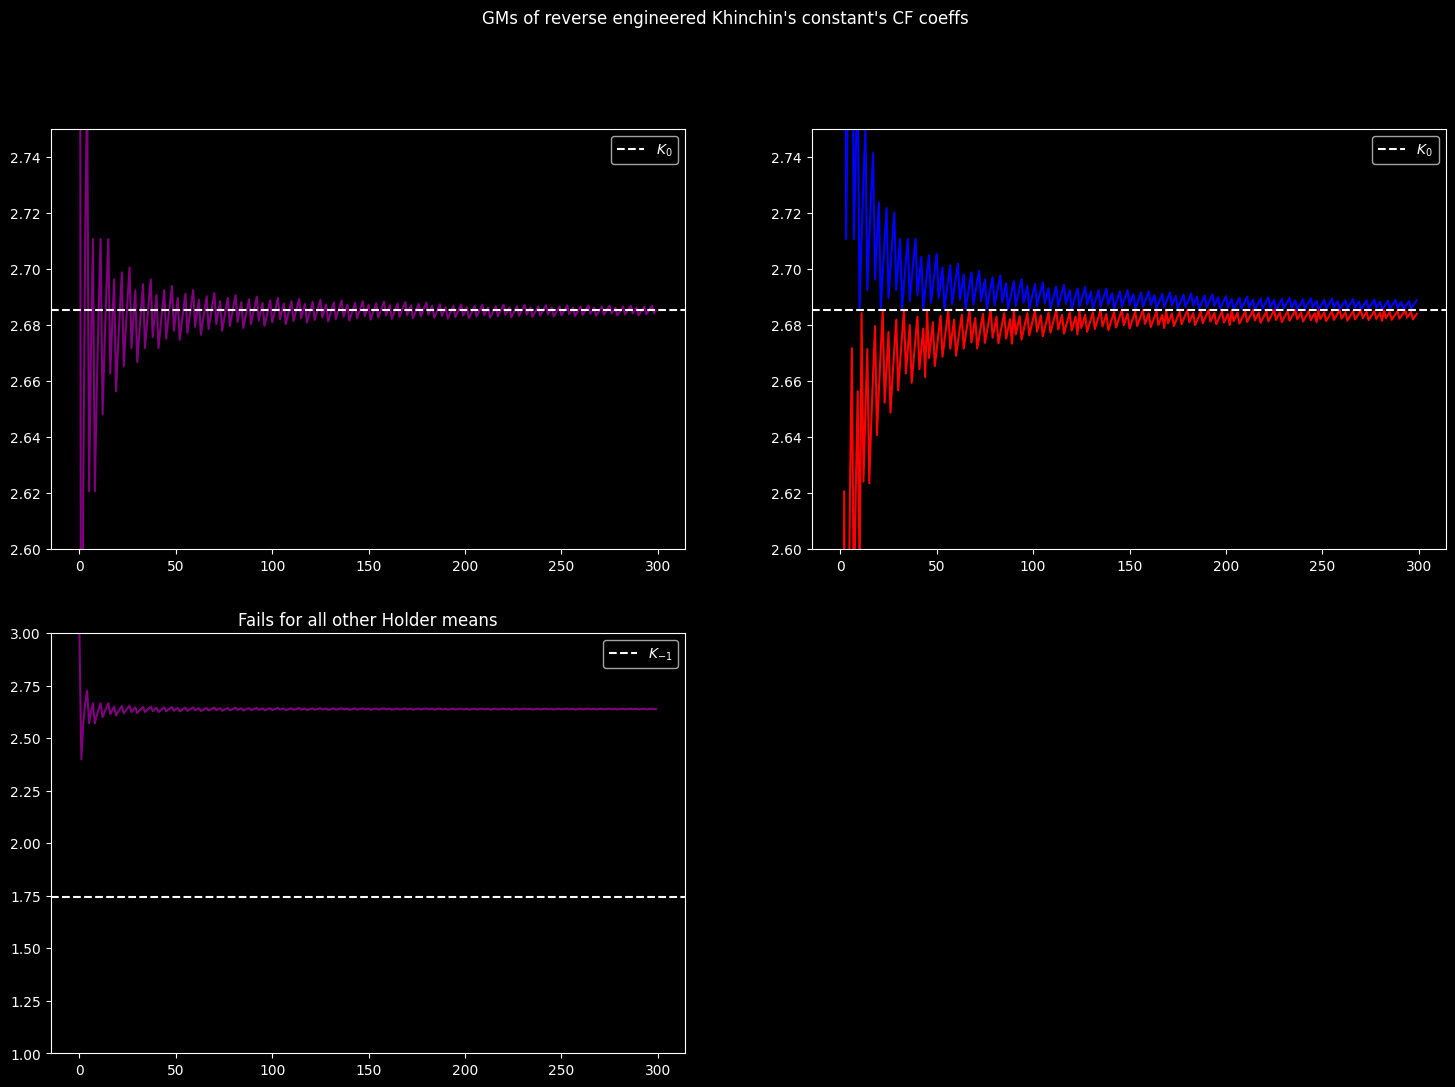

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(18,12))
fig.delaxes(ax[1,1])
line_x_points = np.arange(1, 1+len(means))

plt.sca(ax[0, 0])
plt.plot(line_x_points, means, c='purple')
plt.axhline(K, label=r'$K_0$', color='w', linestyle='--')
plt.ylim(2.6, 2.75)
plt.legend()

plt.sca(ax[0, 1])
plt.plot(line_x_points, compute_cum_GM(rev_khinchin_coeffs_top), c='b')
plt.plot(line_x_points, compute_cum_GM(rev_khinchin_coeffs_bottom), c='r')
plt.axhline(K, label=r'$K_0$', color='w', linestyle='--')
plt.ylim(2.6, 2.75)
plt.legend()

plt.sca(ax[1, 0])
plt.plot(line_x_points, compute_cum_HM(rev_khinchin_coeffs), c='purple')
plt.axhline(1.7454056624073468, label=r'$K_{-1}$', color='w', linestyle='--')
plt.ylim(1, 3)
plt.title('Fails for all other Holder means')
plt.legend()

plt.suptitle("GMs of reverse engineered Khinchin's constant's CF coeffs")
plt.show()

In [ ]:
anim = animate_line_zoom_in(line_x_points, (mp.nstr(rev_khinchin_const, 100) + '...', means))
FFWriter = animation.FFMpegWriter(fps=15)
anim.save('../animations/reverse_khinchin_const.mp4', writer=FFWriter)
plt.close()

  0%|          | 1/300 [00:00<?, ?it/s]